# Setup

In [9]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import pandas as pd
import modellib.io as io
import matplotlib.pyplot as plt

from numpy.linalg import cond
from matrixkit import preconditioning as prec

# Load original test matrices, true block starts and predicted block starts from CNN, GCNm and SVB Algorithm

In [10]:
# Reading original test matrices 
A_orig = np.load('data/matrices/test_matrices_64x64_200.npy')

# Reading block start indicators
_, true_blocks = io.read_from_hdf5('data/datasets/test_dataset_64_200.h5')
cnn_blocks = np.load('data/blockstarts/cnn_predictions.npy')
svb_blocks = np.load('data/blockstarts/svb_predictions_max_16.npy')
gcn_blocks = np.load('data/blockstarts/gcn_predictions.npy')

# Verify Shapes
print(f'Test Matrices Shape: {A_orig.shape}')
print(f'True Blockstarts Shape: {true_blocks.shape}')
print(f'CNN Predictions Shape: {cnn_blocks.shape}')
print(f'SVB Predictions Shape: {svb_blocks.shape}')
print(f'GCN Predictions Shape: {gcn_blocks.shape}')

Test Matrices Shape: (200, 64, 64)
True Blockstarts Shape: (200, 64)
CNN Predictions Shape: (200, 64)
SVB Predictions Shape: (200, 64)
GCN Predictions Shape: (200, 64)



# Create Preconditioner from true and predicted block starts




In [11]:
# Using block starts derived from different methods, generate block Jacobi preconditioners
precs_true = prec.generate_block_jacobi_preconditioner(A_orig, true_blocks)
precs_cnn = prec.generate_block_jacobi_preconditioner(A_orig, cnn_blocks)
precs_gcn = prec.generate_block_jacobi_preconditioner(A_orig, gcn_blocks)
precs_svb = prec.generate_block_jacobi_preconditioner(A_orig, svb_blocks)

b = np.ones((A_orig.shape[0], A_orig.shape[1]))

# Run GMRES Solver & Compare Results
### With and Without Preconditioner from:
    - True Block Starts
    - CNN Predicted Block Starts
    - GCN Predicted Block Starts
    - SVB Predicted Block Starts

In [12]:
# Run GMRES experiments with different preconditioners
input_matrices_list = [
    ('Original Matrices', A_orig) # Option to add differently processed matrices
]

preconditioners_list = [
    ('No Preconditioner', None),
    ('Prec from True Block Starts', precs_true),
    ('Prec from CNN Block Starts', precs_cnn),
    ('Prec from GCN Block Starts', precs_gcn),
    ('Prec from SVB Block Starts', precs_svb)    
]

results_df = prec.run_gmres_experiments(input_matrices_list, preconditioners_list, b)

# Print Results
pd.set_option("display.precision", 2)
results_df

Solving Original Matrices with No Preconditioner...
Solving Original Matrices with Prec from True Block Starts...
Solving Original Matrices with Prec from CNN Block Starts...
Solving Original Matrices with Prec from GCN Block Starts...
Solving Original Matrices with Prec from SVB Block Starts...


,Matrix Type,Preconditioner Type,Converged,Total Systems,Percent Converged,Mean Iterations,Median Iterations,Max Iterations,Min Iterations
0,Original Matrices,No Preconditioner,181,200,90.5,2566.98,1700.0,10381,168
1,Original Matrices,Prec from True Block Starts,190,200,95.0,262.62,111.0,3632,20
2,Original Matrices,Prec from CNN Block Starts,184,200,92.0,258.21,107.0,5116,19
3,Original Matrices,Prec from GCN Block Starts,176,200,88.0,271.42,109.5,3756,16
4,Original Matrices,Prec from SVB Block Starts,180,200,90.0,368.43,119.5,5740,19


# Compare Condition Numbers

In [14]:
# Calculate preconditioned matrices
orig_with_precs_true = A_orig @ precs_true
orig_with_precs_cnn = A_orig @ precs_cnn
orig_with_precs_gcn = A_orig @ precs_gcn
orig_with_precs_svb = A_orig @ precs_svb

In [ ]:
# Calculate condition numbers for each method
def calculate_condition_numbers(matrices):
    return [cond(matrix) for matrix in matrices]

# Calculate condition numbers for each method
cond_orig = calculate_condition_numbers(A_orig)
cond_true = calculate_condition_numbers(orig_with_precs_true)
cond_cnn = calculate_condition_numbers(orig_with_precs_cnn)
cond_gcn = calculate_condition_numbers(orig_with_precs_gcn)
cond_svb = calculate_condition_numbers(orig_with_precs_svb)

# Create condition number statistics
condition_numbers = [{
    'Matrix Type': 'Original Matrix',
    'Mean Condition Number': np.mean(cond_orig),
    'Median Condition Number': np.median(cond_orig),
    'Max Condition Number': np.max(cond_orig),
    'Min Condition Number': np.min(cond_orig)
}, {
    'Matrix Type': 'True Block Starts',
    'Mean Condition Number': np.mean(cond_true),
    'Median Condition Number': np.median(cond_true),
    'Max Condition Number': np.max(cond_true),
    'Min Condition Number': np.min(cond_true)
}, {
    'Matrix Type': 'CNN Block Starts',
    'Mean Condition Number': np.mean(cond_cnn),
    'Median Condition Number': np.median(cond_cnn),
    'Max Condition Number': np.max(cond_cnn),
    'Min Condition Number': np.min(cond_cnn)
}, {
    'Matrix Type': 'GCN Block Starts',
    'Mean Condition Number': np.mean(cond_gcn),
    'Median Condition Number': np.median(cond_gcn),
    'Max Condition Number': np.max(cond_gcn),
    'Min Condition Number': np.min(cond_gcn)
}, {
    'Matrix Type': 'SVB Block Starts',
    'Mean Condition Number': np.mean(cond_svb),
    'Median Condition Number': np.median(cond_svb),
    'Max Condition Number': np.max(cond_svb),
    'Min Condition Number': np.min(cond_svb)
}]

In [18]:
# Create DataFrame from statistics
condition_numbers_df = pd.DataFrame(condition_numbers)

# Add percentage improvement to DataFrame
condition_numbers_df['Improvement (%)'] = (condition_numbers_df['Mean Condition Number'] - condition_numbers_df['Mean Condition Number'].iloc[0]) / condition_numbers_df['Mean Condition Number'].iloc[0] * 100 * -1

# Print DataFrame
pd.set_option("display.precision", 2)
condition_numbers_df

,Matrix Type,Mean Condition Number,Median Condition Number,Max Condition Number,Min Condition Number,Improvement (%)
0,Original Matrix,3576.48,586.02,2.63e+05,115.04,0.00
1,True Block Starts,82632.10,15641.84,4.64e+06,2375.94,2210.43
2,CNN Block Starts,90957.38,16085.36,6.58e+06,2375.97,2443.21
3,GCN Block Starts,122386.18,19906.97,9.57e+06,3422.49,3321.97
4,SVB Block Starts,94070.62,15189.29,4.34e+06,3005.24,2530.26


## Plot Condition Numbers


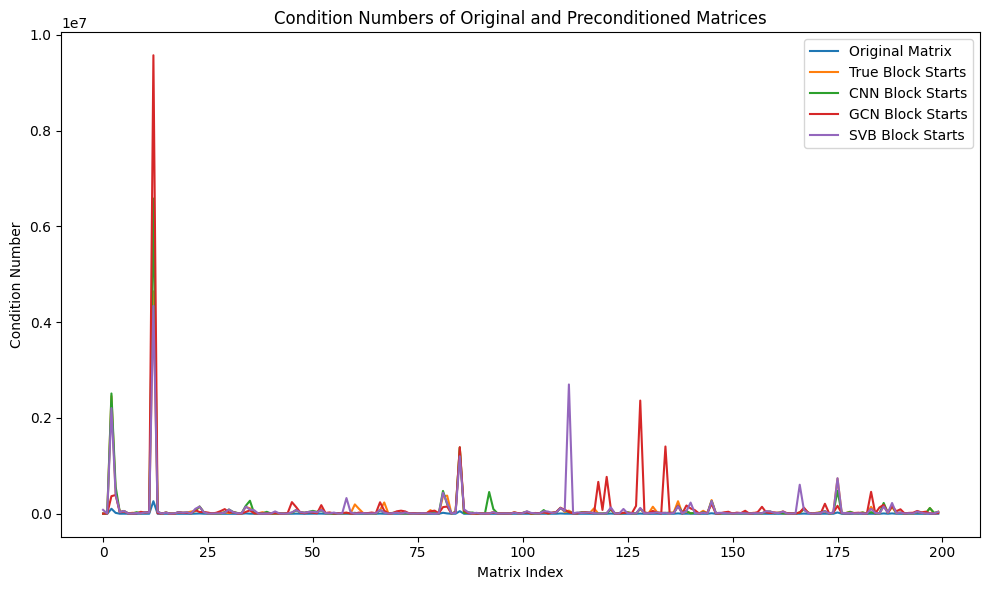

In [19]:
# Plot condition numbers
plt.figure(figsize=(10, 6))
plt.plot(cond_orig, label='Original Matrix')
plt.plot(cond_true, label='True Block Starts')
plt.plot(cond_cnn, label='CNN Block Starts')
plt.plot(cond_gcn, label='GCN Block Starts')
plt.plot(cond_svb, label='SVB Block Starts')
plt.xlabel('Matrix Index')
plt.ylabel('Condition Number')
plt.title('Condition Numbers of Original and Preconditioned Matrices')
plt.legend()
plt.tight_layout()
plt.show()

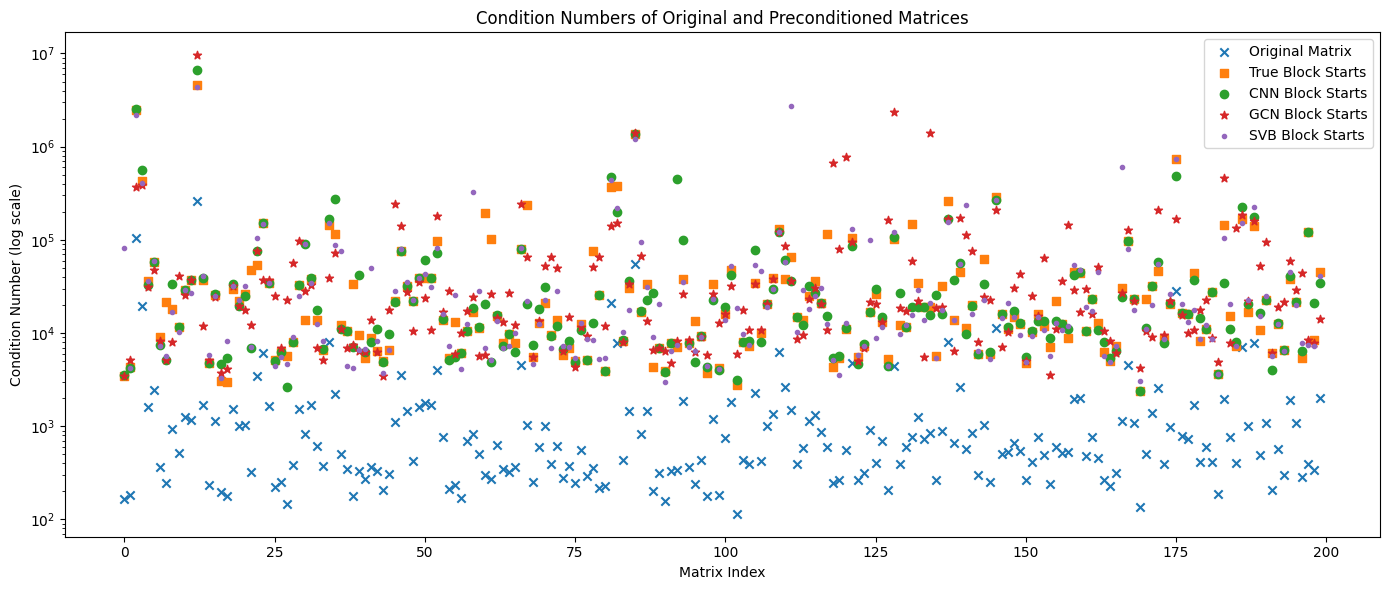

In [20]:
# Scatterplot of condition numbers
plt.figure(figsize=(14, 6))
plt.scatter(range(len(cond_orig)), cond_orig, label='Original Matrix', marker='x')
plt.scatter(range(len(cond_true)), cond_true, label='True Block Starts', marker='s')
plt.scatter(range(len(cond_cnn)), cond_cnn, label='CNN Block Starts', marker='o')
plt.scatter(range(len(cond_gcn)), cond_gcn, label='GCN Block Starts', marker='*')
plt.scatter(range(len(cond_svb)), cond_svb, label='SVB Block Starts', marker='.')
plt.xlabel('Matrix Index')
plt.ylabel('Condition Number (log scale)')
plt.gca().set_yscale('log')
plt.title('Condition Numbers of Original and Preconditioned Matrices')
plt.legend()
plt.tight_layout()
plt.show()